In [1]:
from lxml import html
import re
from transformers import BertTokenizerFast
import os
import torch
import multiprocessing
from multiprocessing import Pool
import time 
import json

TOKENIZER = BertTokenizerFast.from_pretrained("bert-base-uncased")
MAX_SEQ_LENGTH = 512
PAD_TOKEN = "[PAD]"
PAD_TOKEN_ID = 0
PADDING_MASK = 0
TEXT_MASK = 1



def __get_prop(node, name):
    title = node.get("title")
    props = title.split(";")
    for prop in props:
        (key, args) = prop.split(None, 1)
        args = args.strip('"')
        if key == name:
            return args
    return None

def read_hocr_file(hocr_file):
        text_buffer = []
        bbox_buffer = []
        doc = html.parse(hocr_file)
        for page in doc.xpath("//*[@class='ocr_page']"):
            page_bbox = [int(x) for x in __get_prop(page, "bbox").split()]
            width, height = page_bbox[2], page_bbox[3]
            for word in doc.xpath("//*[@class='ocrx_word']"):
                textnodes = word.xpath(".//text()")
                s = "".join([text for text in textnodes])
                text = re.sub(r"\s+", " ", s).strip()
                if text:
                    text_buffer.append(text)
                    bbox = [int(x) for x in __get_prop(word, "bbox").split()]
                    bbox = [
                        bbox[0] / width,
                        bbox[1] / height,
                        bbox[2] / width,
                        bbox[3] / height,
                    ]
                    bbox = [int(x * 1000) for x in bbox]
                    bbox_buffer.append(bbox)
        return text_buffer, bbox_buffer
    
    
def convert_to_features(text_buff,bbox_buff):    
    bboxes = []
    tokens = []
    
    if len(text_buff)==0:
        bboxes.append([0, 0, 0, 0])
        tokens.append(PAD_TOKEN)
    
    
    for token, bbox in zip(text_buff, bbox_buff):
        sub_tokens = TOKENIZER.tokenize(token)
        for sub_token in sub_tokens:
            bboxes.append(bbox)
            tokens.append(sub_token)
    
    bboxes = bboxes[: MAX_SEQ_LENGTH - 2]
    bboxes = [[0, 0, 0, 0]] + bboxes + [[1000, 1000, 1000, 1000]]
    
    tokens = tokens[: MAX_SEQ_LENGTH - 2]
    input_ids = TOKENIZER.convert_tokens_to_ids(tokens)
    input_ids = [TOKENIZER.cls_token_id] + input_ids + [TOKENIZER.sep_token_id]
    
    attention_mask = [TEXT_MASK] * len(input_ids)
    
    padding_length = MAX_SEQ_LENGTH - len(input_ids)
    
    input_ids = input_ids + [PAD_TOKEN_ID] * padding_length
    bboxes = bboxes + [[0, 0, 0, 0]] * padding_length
    attention_mask = attention_mask + [PADDING_MASK] * padding_length

    return {
        "input_ids":torch.tensor([input_ids],dtype=torch.long),
        "bbox":torch.tensor([bboxes],dtype=torch.long),
        "attention_mask":torch.tensor([attention_mask],dtype=torch.long),
    }



In [2]:
from transformers import BertConfig, BertModel, BertPreTrainedModel
from transformers.modeling_bert import BertLayerNorm

from torch import nn

LAYOUTLM_PRETRAINED_MODEL_ARCHIVE_MAP = {}

LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP = {}

class LayoutlmConfig(BertConfig):
    pretrained_config_archive_map = LAYOUTLM_PRETRAINED_CONFIG_ARCHIVE_MAP
    model_type = "bert"

    def __init__(self, max_2d_position_embeddings=1024, **kwargs):
        super().__init__(**kwargs)
        self.max_2d_position_embeddings = max_2d_position_embeddings
        
class LayoutlmEmbeddings(nn.Module):
    def __init__(self, config):
        super(LayoutlmEmbeddings, self).__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.x_position_embeddings = nn.Embedding(config.max_2d_position_embeddings, config.hidden_size)
        self.y_position_embeddings = nn.Embedding(config.max_2d_position_embeddings, config.hidden_size)
        self.h_position_embeddings = nn.Embedding(config.max_2d_position_embeddings, config.hidden_size)
        self.w_position_embeddings = nn.Embedding(config.max_2d_position_embeddings, config.hidden_size)
        self.token_type_embeddings = nn.Embedding(config.type_vocab_size, config.hidden_size)

    
        self.LayerNorm = BertLayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self,input_ids,bbox):
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        
        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        left_position_embeddings = self.x_position_embeddings(bbox[:, :, 0])
        upper_position_embeddings = self.y_position_embeddings(bbox[:, :, 1])
        right_position_embeddings = self.x_position_embeddings(bbox[:, :, 2])
        lower_position_embeddings = self.y_position_embeddings(bbox[:, :, 3])
        h_position_embeddings = self.h_position_embeddings(bbox[:, :, 3] - bbox[:, :, 1])
        w_position_embeddings = self.w_position_embeddings(bbox[:, :, 2] - bbox[:, :, 0])

        embeddings = (
            words_embeddings
            + position_embeddings
            + left_position_embeddings
            + upper_position_embeddings
            + right_position_embeddings
            + lower_position_embeddings
            + h_position_embeddings
            + w_position_embeddings
        )
        
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings


class LayoutlmModel(BertModel):

    config_class = LayoutlmConfig
    pretrained_model_archive_map = LAYOUTLM_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "bert"

    def __init__(self, config):
        super(LayoutlmModel, self).__init__(config)
        self.embeddings = LayoutlmEmbeddings(config)
        self.init_weights()

    def forward(self,input_ids,bbox,attention_mask,):
        
        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, bbox)
        head_mask = [None] * self.config.num_hidden_layers
        encoder_outputs = self.encoder(embedding_output, extended_attention_mask,head_mask=head_mask)

        sequence_output = encoder_outputs[0]
        return sequence_output


In [3]:
config = LayoutlmConfig.from_pretrained("../models/layoutlm-base-uncased")
model = LayoutlmModel.from_pretrained("../models/layoutlm-base-uncased",config=config)

def process_document_batch(document_batch):

    batch_info = []
    
    for document in document_batch:
        text_buff,bbox_buff = read_hocr_file(document)
        batch_info.append(convert_to_features(text_buff,bbox_buff))
    
    input_ids = []
    bbox_es = []
    attention_masks = []
    for d in batch_info:
        input_ids.append(d['input_ids'])
        bbox_es.append(d['bbox'])
        attention_masks.append(d['attention_mask'])

    input_ids = torch.cat(input_ids)
    bbox_es = torch.cat(bbox_es)
    attention_masks = torch.cat(attention_masks)
    
    with torch.no_grad():
        preds = model.forward(input_ids,bbox_es,attention_masks)
    
    return preds

In [4]:
BATCH_SIZE = 50

DATASET_NAME = "SMALL_TOBACCO"

hOCR_data_location = "../data/SMALL_TOBACCO/document_hOCR".format(DATASET_NAME)

document_types = os.listdir(hOCR_data_location)
doc_types = []
documents = []

for doc_type in document_types:
    documents_of_this_type = os.listdir(hOCR_data_location+"/{}/".format(doc_type))
    documents+=["{}/{}/{}".format(hOCR_data_location,doc_type,doc) for doc in documents_of_this_type]
    doc_types+= [doc_type]*len(documents_of_this_type)

    
document_batches = []

batch = []
for ix,d in enumerate(documents):
    if len(batch)==BATCH_SIZE:
        document_batches.append(batch)
        batch = []
    batch.append(d)
document_batches.append(batch)

In [ ]:
NUM_WORKERS = 4

pool = Pool(NUM_WORKERS)
start = time.time()
document_embeddings = pool.map(process_document_batch,document_batches)
document_embeddings = torch.cat(document_embeddings)
stop = time.time()
pool.close()
print("Processing {} docs took {} s".format(len(documents),stop-start))


In [119]:
os.makedirs("../data/{}/document_embeddings".format(DATASET_NAME))
os.makedirs("../data/{}/document_metadata".format(DATASET_NAME))


In [121]:
for ix,document in enumerate(documents):
    
    document_id = document.split("/")[-1].split('.hOCR')[0]
    
    text_buff,bbox_buff = read_hocr_file(document)
    
    tokens = []
    bboxes = []
    
    for token, bbox in zip(text_buff, bbox_buff):
            sub_tokens = TOKENIZER.tokenize(token)
            for sub_token in sub_tokens:
                bboxes.append(bbox)
                tokens.append(sub_token)
    
    tokens = ['cls']+tokens+['sep']
    bboxes = [[0,0,0,0]]+bboxes+[[0,0,0,0]]
    
    with open("../data/{}/document_metadata/{}.json".format(DATASET_NAME,document_id),"w+") as f:
        json.dump({
                    "tokenized_text":tokens,
                    "bounding_boxes":bboxes,
                    "label":doc_types[ix]
                  },f)
    np.save("../data/{}/document_embeddings/{}.npy".format(DATASET_NAME,document_id),
           document_embeddings[ix,:len(tokens)].numpy())
        

In [90]:
def un_tokenize(tokenized_text):
    return "".join([s.strip() for s in " ".join(tokens).split("##")])

"=D oT 097985 RIF_ RJR INTEROFFICE MEMORANDUM CO N FI f) E NTA | Subject: Extramural UBS and Date: October 8, 1985 Drosophila Assays yr. From: Dr. R. Beskin To: Dr. W. Sf Simmon a) ply “le le This is to update you on the plan for conducting unscheduled DNA synthesis (UDS) and SLRL Drosophila assays extramurally. In conversations with G. Burger and J. Hayes it was confirmed that we would ask SRI and Litton (Hazelton) to conduct the in-vitro UDS assay using two samples of cigarette condensate. One sample would be from a Kentucky reference cigarette (1R4F) and the second comparative sample would be from a RAN product. The cost : associated with this assay for two (2) samples at SRI would be , $11,000 and at Litton would be $10,400, for a total of $21,400. Johnnie Hayes has contacted Or. Valencia at Wisconsin and she is fowarding a price list to us for the Drosophila assay. Litton charges $23,500 for a routine Drosophila assay. I suggest that we meet with Gary, Johnnie, Chin, and Bob Suber

In [ ]:
def un_tokenize(tokenized_text):
    return "".join([s.strip() for s in " ".join(tokens).split("##")])

In [122]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
label_encoder =  LabelEncoder().fit(doc_types)
labels = label_encoder.transform(doc_types)

X_train, X_test, y_train, y_test = train_test_split(document_embeddings[:,0,:], labels, test_size=0.3,random_state=10)

In [123]:
from sklearn.neural_network import MLPClassifier

clf = LogisticRegression(class_weight='balanced').fit(X_train,y_train)
print(classification_report(clf.predict(X_test),y_test,target_names=type_names))

              precision    recall  f1-score   support

      Letter       0.89      0.90      0.90        62
  Scientific       0.91      0.96      0.94        98
      Report       0.80      0.77      0.78        77
        ADVE       0.88      0.86      0.87       164
        Memo       0.87      0.88      0.87       146
        Note       0.88      0.50      0.64        14
      Resume       0.68      0.87      0.76        39
        Form       0.66      0.62      0.64        72
        News       0.96      0.96      0.96        28
       Email       0.70      0.63      0.67        41

    accuracy                           0.83       741
   macro avg       0.82      0.80      0.80       741
weighted avg       0.83      0.83      0.83       741



/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
clf = LinearSVC(class_weight='balanced').fit(X_train,y_train)
print(classification_report(clf.predict(X_test),y_test,target_names=type_names))

In [33]:
from sklearn.manifold import TSNE

embedded_docs = TSNE(2).fit_transform(document_embeddings[:,0,:])


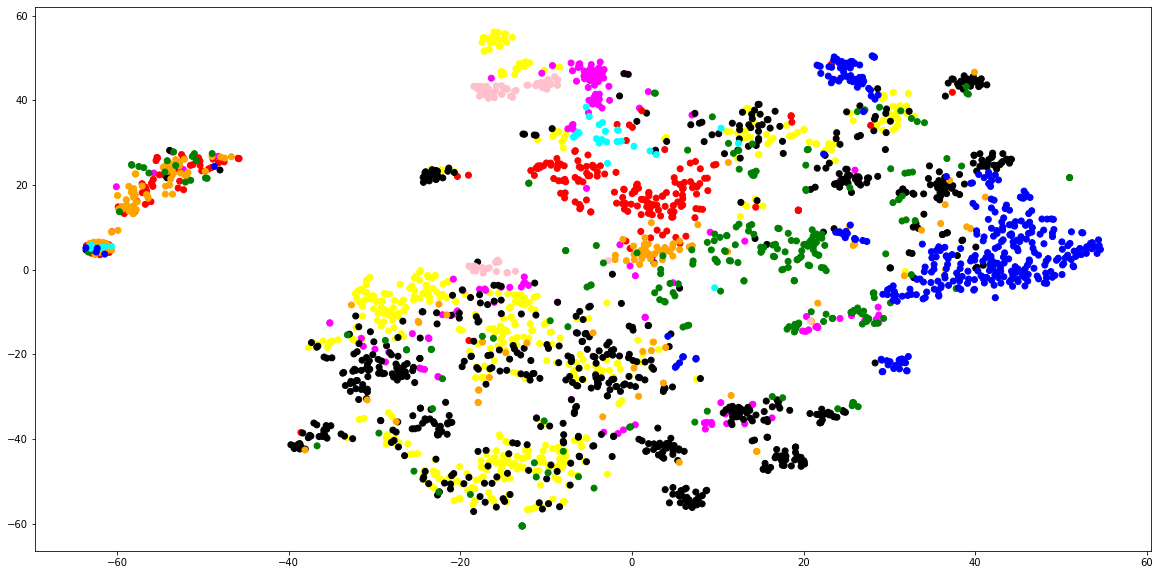

In [34]:
import matplotlib.pyplot as plt

colors = np.array(['red','blue','green','yellow','black','cyan','orange','black','pink','magenta'])

plt.figure(figsize=(20,10))
plt.scatter(embedded_docs[:,0],embedded_docs[:,1],c=colors[labels],)

In [55]:
def rectangle_drawing_coordinates(bbox):
    coordinates = []
    coordinates += [bbox[0],bbox[1]]
    coordinates += [bbox[2],bbox[1]]
    coordinates += [bbox[2],bbox[3]]
    coordinates += [bbox[0],bbox[3]]
    coordinates += [bbox[0],bbox[1]]    
    return coordinates
    

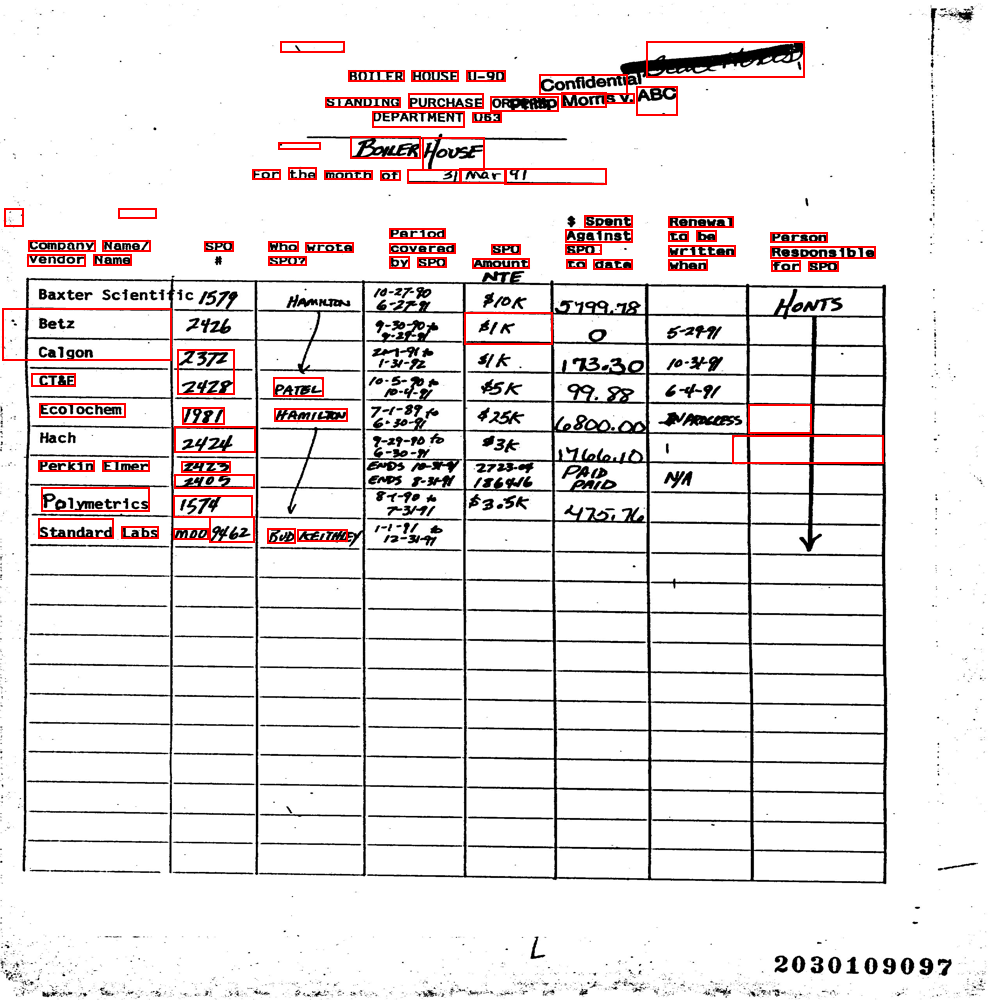

In [70]:
from PIL import Image,ImageDraw
from IPython.display import display # to display images

im = Image.open("../../Tobacco3482-jpg/Form/2030109097.jpg").convert('RGB')
im = im.resize((1000,1000))

draw = ImageDraw.Draw(im)

for text,box in zip(text_buff,bbox_buff):
    if len(text)<=1:
        continue
    
    draw.line(rectangle_drawing_coordinates(box), width=2,fill='red')
    #draw.text((box[0],box[1]-5),text,fill='blue')
    
display(im)